<a href="https://colab.research.google.com/github/pearl-yu/twitch_project/blob/main/10112022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Run this line if using Colab.
!git clone https://github.com/pearl-yu/twitch_project
%cd twitch_project/

Cloning into 'twitch_project'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 101 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (101/101), 614.22 KiB | 5.29 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/twitch_project


In [ ]:
## So we can write the dataset to google drive (not github. need to upload to github manually for now.)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests  # get the content from the API by using the get() method. json() method converts the API response to JSON format for easy handling.
import json   # to work with the returned json content from API.
import numpy as np
import pandas as pd

from pandas import json_normalize

import matplotlib.pyplot as plt

from datetime import datetime
import re

In [ ]:
## Pearl's credentials
client_id = 'tamrylbvlu3wub4r8c5fddwsou246x'
client_secret= 'y4enh38kpiwkh7j00nqvv185ttsedw'

# Defining the URL to which we will make the request
url = 'https://id.twitch.tv/oauth2/token'
# Defining the parameters to be passed to the request
body = {
  'client_id'     : client_id,
  'client_secret' : client_secret,
  'grant_type'    : 'client_credentials'
}

access_code = requests.post(url, params=body) # Making a POST request to the URL to retrieve the access token
access_token = json.loads(access_code.text) #access token response is a JSON-encoded app access token

access_token = access_token['access_token']

With the sample:
- Pull user ids by calling the https://dev.twitch.tv/docs/api/reference#get-users endpoint, specifying the login parameter.
- Pull the video ids following this: https://github.com/btjmga/twitch-getallvods  (I didn't have the code to pull ALL the vids)
- Pull the chatfiles of these videos. (using the downloader https://github.com/lay295/TwitchDownloader is easy. Check  https://github.com/Chaparro/rechat-dl and https://github.com/malciin/twitch-comments-downloader for code.)
- Construct variables from the chatfile.
- Call what other stuff? 

In [ ]:
# reference - read in multiple files: https://sparkbyexamples.com/pandas/pandas-read-multiple-csv-files/
# Import libraries
import glob

# Get CSV files list from a folder
path = './data/sample_by_growing_sullygnome'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
df_list = (pd.read_csv(file) for file in csv_files) # This creates a list of dataframes
df   = pd.concat(df_list) # Concatenate all DataFrames

df = df.sample(frac=1) # shuffle the order of rows
print(df.shape)

df_en = df[df['Language'] == 'English'].reset_index()
#path = './data/sample_by_growing_sullygnome/Fastest growing Twitch streamers, past 30 days - SullyGnome (7).csv'
#df = pd.read_csv(path)

print(df_en.shape)
df_en.head()

(900, 13)
(314, 14)


,index,Unnamed: 0,Unnamed: 1,Channel,Watch time (mins),Stream time (mins),Peak viewers,Average viewers,Followers,Followers gained,Partnered,Mature,Language,Unnamed: 12
0,52,53,https://static-cdn.jtvnw.net/jtv_user_pictures...,iiTzTimmy,367448175,43335,22810,8479,2453270,216831,True,False,English,iiTzTimmy
1,71,972,https://static-cdn.jtvnw.net/jtv_user_pictures...,PlinkzTV,3151275,34710,533,90,107435,8102,False,False,English,PlinkzTV
2,94,1495,https://static-cdn.jtvnw.net/jtv_user_pictures...,pekggysoyed,386610,1905,881,202,6222,5721,False,False,English,pekggysoyed
3,59,2960,https://static-cdn.jtvnw.net/jtv_user_pictures...,AkzOnTop,15600,1815,26,8,3455,3161,False,False,English,AkzOnTop
4,81,3482,https://static-cdn.jtvnw.net/jtv_user_pictures...,General_Mars,38430,9210,21,4,3802,2726,False,True,English,General_Mars


# **A big thing! Maybe it's faster to download https://sullygnome.com/channels/30/followergrowth and pull out stream id, integrate that into the following data. There we have the content category information.**

In [ ]:
def api_info(url = 'https://api.twitch.tv/helix/users?id=', key_series = df['Channel'], n = 5):
    '''
    url is the api URL
    key_series is a pandas series of the keys. check on the API reference page to see what should be the key
    n is the number of keys you wanna pull info from
    '''
    headers = {
            'Authorization' : 'Bearer '+str(access_token),
            'Client-Id' : client_id
        }

    temp_df = pd.DataFrame()
    for i in range(0,n) :
        temp_response = requests.get(url+str(key_series[i]), headers=headers)
        # Load the JSON
        temp_response_json = json.loads(temp_response.text)
        if list(temp_response_json.keys())[0] == 'error':
            continue
        else:
            temp_data = temp_response_json['data']
            temp_df_temp = pd.DataFrame.from_dict(json_normalize(temp_data), orient='columns')
        
            frames = [temp_df, temp_df_temp]
            temp_df = pd.concat(frames, ignore_index=True)
    
    print(temp_df.shape)
    print(temp_df.columns)
    
    return temp_df

In [ ]:
## call the get_users end points to retrieve user id
user_df = api_info(url = 'https://api.twitch.tv/helix/users?login=',
         key_series = df_en['Channel'], 
         n = 100)

print(user_df.shape)
user_df.head()

(97, 10)
Index(['id', 'login', 'display_name', 'type', 'broadcaster_type',
       'description', 'profile_image_url', 'offline_image_url', 'view_count',
       'created_at'],
      dtype='object')
(97, 10)


,id,login,display_name,type,broadcaster_type,description,profile_image_url,offline_image_url,view_count,created_at
0,45302947,iitztimmy,iiTzTimmy,,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,46151009,2013-06-28T04:15:32Z
1,580691169,plinkztv,PlinkzTV,,,why you looking here lol.. follow or i sad 😢,https://static-cdn.jtvnw.net/jtv_user_pictures...,,1054382,2020-09-08T22:48:56Z
2,826212800,pekggysoyed,pekggysoyed,,,มือปืน ที่คมที่สุดในตอนนี้,https://static-cdn.jtvnw.net/jtv_user_pictures...,,0,2022-09-17T11:50:28Z
3,229285909,akzontop,AkzOnTop,,affiliate,The names AkzOnTop. WE GET LIT IN HEREEE HIT T...,https://static-cdn.jtvnw.net/jtv_user_pictures...,,3128,2018-06-07T00:53:11Z
4,35112592,general_mars,General_Mars,,affiliate,I’ve been streaming on and off since at least ...,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,79930,2012-08-20T02:32:21Z


In [ ]:
## call the get_videos end points to retrieve all video ids of the users
video_df = api_info(url = 'https://api.twitch.tv/helix/videos?user_id=',
         key_series = user_df['id'], 
         n = len(user_df))

print(video_df.shape)
video_df.head()

(1595, 17)
Index(['id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'muted_segments'],
      dtype='object')
(1595, 17)


,id,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,thumbnail_url,viewable,view_count,language,type,duration,muted_segments
0,1619944979,41371583835,45302947,iitztimmy,iiTzTimmy,Ultimate Challenge Gauntlet with softi @ Twitc...,,2022-10-09T22:18:53Z,2022-10-09T22:18:53Z,https://www.twitch.tv/videos/1619944979,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,135401,en,archive,3h39m37s,None
1,1619008572,41367685499,45302947,iitztimmy,iiTzTimmy,Apex Twitch Rivals LIVE @ TwitchCon / Follow m...,,2022-10-08T22:41:21Z,2022-10-08T22:41:21Z,https://www.twitch.tv/videos/1619008572,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,108462,en,archive,2h18m1s,None
2,1618991112,41367613467,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-08T22:17:40Z,2022-10-08T22:17:40Z,https://www.twitch.tv/videos/1618991112,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,21690,en,archive,23m24s,None
3,1617881723,41362847115,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-07T19:54:06Z,2022-10-07T19:54:06Z,https://www.twitch.tv/videos/1617881723,https://static-cdn.jtvnw.net/cf_vods/d2nvs3185...,public,7383,en,archive,1m57s,None
4,1617880267,40315785945,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-07T19:52:24Z,2022-10-07T19:52:24Z,https://www.twitch.tv/videos/1617880267,https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9...,public,1527,en,archive,56s,None


In [ ]:
# Some pre-processing of the video_df
video_df['created_at'] = pd.to_datetime(video_df['created_at']) 
video_df['duration_min'] = video_df['duration'].str.replace("h", '*60+').str.replace('m','*1+').str.replace('s','*(1/60)').apply(eval) # convert duration to numeric in minutes

In [ ]:
# Get some simple statistics
print(video_df['created_at'].min(),video_df['created_at'].max())

video_df.groupby('user_id').agg({'id':'count',
                                 'created_at': [min,max],
                                 'duration_min':[min,max,'mean'],
                                 'view_count':'mean'})

2013-07-12 13:00:03+00:00 2022-10-11 23:20:12+00:00


id                created_at                            \
          count                       min                       max   
user_id                                                               
104211056     8 2022-06-02 17:56:43+00:00 2022-10-11 12:43:52+00:00   
113025683    20 2022-05-06 19:39:28+00:00 2022-10-04 08:36:40+00:00   
114856888    20 2022-09-20 16:10:49+00:00 2022-10-11 16:15:34+00:00   
117349875    20 2022-09-23 13:51:41+00:00 2022-10-05 17:15:02+00:00   
117583640    10 2022-08-17 01:33:31+00:00 2022-09-29 02:10:26+00:00   
...         ...                       ...                       ...   
833317325    14 2022-09-30 20:47:18+00:00 2022-10-08 00:03:36+00:00   
84316241     20 2022-09-04 20:53:35+00:00 2022-10-10 21:29:57+00:00   
86180772     20 2022-09-16 17:11:20+00:00 2022-10-11 08:06:38+00:00   
88084663     14 2022-08-15 00:50:51+00:00 2022-10-07 22:19:20+00:00   
92372244     20 2022-09-11 01:15:42+00:00 2022-10-07 22:44:17+00:00   

          duration_min                              view_count  
                   min          max        mean           mean  
user_id                                                         
104211056     1.116667   488.566667  346.277083   52413.125000  
113025683     1.233333   373.666667   61.798333      78.550000  
114856888    63.400000   243.500000  167.556667    4983.000000  
117349875    47.516667   390.433333  209.381667   13951.150000  
117583640   102.066667   310.300000  207.433333  226097.700000  
...                ...          ...         ...            ...  
833317325     0.333333   366.300000   52.122619    4799.500000  
84316241    349.666667  2740.666667  820.185833  181612.500000  
86180772      1.550000  1210.166667  357.110833    5845.800000  
88084663     76.766667   789.533333  441.979762  970295.071429  
92372244      5.966667   561.333333  205.430000   60289.200000  

[89 rows x 7 columns]

In [ ]:
user_temp = user_df[['id', 'broadcaster_type','description', 'profile_image_url', 'offline_image_url', 'created_at']]
user_temp.columns = ['user_id','broadcaster_type','broadcast_description','broadcaster_profile_image_url', 'broadcaster_offline_image_url', 'broadcaster_created_at']

video_df_merge= pd.merge(video_df, 
                         user_temp,  
                         how='left', left_on=['user_id'], right_on = ['user_id'])

print(video_df_merge.columns)
video_df_merge.head()

Index(['id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'muted_segments', 'duration_min', 'broadcaster_type',
       'broadcast_description', 'broadcaster_profile_image_url',
       'broadcaster_offline_image_url', 'broadcaster_created_at'],
      dtype='object')


,id,stream_id,user_id,user_login,user_name,title,description,created_at,published_at,url,...,language,type,duration,muted_segments,duration_min,broadcaster_type,broadcast_description,broadcaster_profile_image_url,broadcaster_offline_image_url,broadcaster_created_at
0,1619944979,41371583835,45302947,iitztimmy,iiTzTimmy,Ultimate Challenge Gauntlet with softi @ Twitc...,,2022-10-09 22:18:53+00:00,2022-10-09T22:18:53Z,https://www.twitch.tv/videos/1619944979,...,en,archive,3h39m37s,None,219.616667,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-06-28T04:15:32Z
1,1619008572,41367685499,45302947,iitztimmy,iiTzTimmy,Apex Twitch Rivals LIVE @ TwitchCon / Follow m...,,2022-10-08 22:41:21+00:00,2022-10-08T22:41:21Z,https://www.twitch.tv/videos/1619008572,...,en,archive,2h18m1s,None,138.016667,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-06-28T04:15:32Z
2,1618991112,41367613467,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-08 22:17:40+00:00,2022-10-08T22:17:40Z,https://www.twitch.tv/videos/1618991112,...,en,archive,23m24s,None,23.400000,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-06-28T04:15:32Z
3,1617881723,41362847115,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-07 19:54:06+00:00,2022-10-07T19:54:06Z,https://www.twitch.tv/videos/1617881723,...,en,archive,1m57s,None,1.950000,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-06-28T04:15:32Z
4,1617880267,40315785945,45302947,iitztimmy,iiTzTimmy,Verizon Behind the Scenes. #ad/ Follow my soci...,,2022-10-07 19:52:24+00:00,2022-10-07T19:52:24Z,https://www.twitch.tv/videos/1617880267,...,en,archive,56s,None,0.933333,partner,Where dreams are made,https://static-cdn.jtvnw.net/jtv_user_pictures...,https://static-cdn.jtvnw.net/jtv_user_pictures...,2013-06-28T04:15:32Z


In [ ]:
video_df_merge.to_csv('video_df_merge.csv')

In [ ]:
## retrieve chat files of these videos.
# https://pypi.org/project/chat-downloader/
!pip install chat-downloader  # Need to install this everytime if you're using Colab.
from chat_downloader import ChatDownloader

In [ ]:
## First we take a look at what data there is about the chats
url = video_df['url'][1]
chat = ChatDownloader().get_chat(url)       # create a generator
         # print the formatted message

# For each chat message, this is the full structure
next(chat)

{'message_id': '56dfa958-be91-4bd7-8679-979e1531f545',
 'timestamp': 1665268893255000,
 'time_in_seconds': 10.555,
 'author': {'display_name': 'bobo_n',
  'id': '566592468',
  'name': 'bobo_n',
  'type': 'user',
  'bio': "I would like to remain unknown.Don't check whispers/dm often. ",
  'created_at': 1597320910088820,
  'images': [{'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/3c4d4bfb-42e9-437d-ba41-caf351106950-profile_image-300x300.png',
    'width': 300,
    'height': 300,
    'id': '300x300'},
   {'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/3c4d4bfb-42e9-437d-ba41-caf351106950-profile_image-70x70.png',
    'width': 70,
    'height': 70,
    'id': '70x70'}],
  'badges': [{'name': 'subscriber',
    'version': 12,
    'title': '1-Year Subscriber',
    'description': '1-Year Subscriber',
    'click_action': 'subscribe_to_channel',
    'click_url': '',
    'icons': [{'url': 'https://static-cdn.jtvnw.net/badges/v1/17c24133-f3e5-4b36-92f5-27dda8384523/1',
      'widt

In [ ]:
## First we take a look at what data there is about the chats
url = video_df['url'][0]
chat = ChatDownloader().get_chat(url)       # create a generator
         # print the formatted message

# For each chat message, this is the full structure
next(chat)

{'message_id': '91ef235a-3a39-4102-88e7-3286b434b51a',
 'timestamp': 1665353968134000,
 'time_in_seconds': 34.434,
 'author': {'display_name': 'Mar0n1_',
  'id': '536714910',
  'name': 'mar0n1_',
  'type': 'user',
  'bio': None,
  'created_at': 1590687785273644,
  'images': [{'url': 'https://static-cdn.jtvnw.net/user-default-pictures-uv/41780b5a-def8-11e9-94d9-784f43822e80-profile_image-300x300.png',
    'width': 300,
    'height': 300,
    'id': '300x300'},
   {'url': 'https://static-cdn.jtvnw.net/user-default-pictures-uv/41780b5a-def8-11e9-94d9-784f43822e80-profile_image-70x70.png',
    'width': 70,
    'height': 70,
    'id': '70x70'}],
  'colour': '#FF0000'},
 'source': 'chat',
 'state': 'published',
 'message': 'yo first',
 'time_text': '0:34',
 'message_type': 'text_message'}

In [ ]:
next(chat)

{'message_id': '741657a0-7d3d-4421-adc5-b113a8239428',
 'timestamp': 1665353978988000,
 'time_in_seconds': 45.288,
 'author': {'display_name': 'StreamElements',
  'id': '100135110',
  'name': 'streamelements',
  'type': 'user',
  'bio': 'Elevate your content with www.StreamElements.com ✔️Free forever ✔️Legendary Service ✔️Trusted by the Best',
  'created_at': 1440188714224473,
  'images': [{'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/streamelements-profile_image-a89b9d61499d365f-300x300.png',
    'width': 300,
    'height': 300,
    'id': '300x300'},
   {'url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/streamelements-profile_image-a89b9d61499d365f-70x70.png',
    'width': 70,
    'height': 70,
    'id': '70x70'}],
  'badges': [{'name': 'moderator',
    'version': 1,
    'title': 'Moderator',
    'description': 'Moderator',
    'click_action': 'none',
    'click_url': '',
    'icons': [{'url': 'https://static-cdn.jtvnw.net/badges/v1/3267646d-33f0-4b17-b3df-f923a41db1d0/

In [ ]:
next(chat).keys()

dict_keys(['message_id', 'timestamp', 'time_in_seconds', 'author', 'source', 'state', 'message', 'time_text', 'message_type'])

In [ ]:
next(chat)['author'].keys()

dict_keys(['display_name', 'id', 'name', 'type', 'bio', 'created_at', 'images', 'badges', 'colour'])

# **About the author, there're badges information that indicates if subscriber, if VIP, if partner streamer, etc. These should definitely be the controls. Also cheermotes and Emotes?**

In [ ]:
# define function to get chat files.
import itertools

def get_chat(key_series = video_df['url'],n = 5, n_message_limit = 100):
  '''
    key_series is a pandas series of video urls.
    n is the number of videos you wanna pull chat from
    n_message_limit is the limit of messages you wanna pull from each video
    '''
  timestamp = []
  time_in_seconds = []
  messages = []
  author_id = []
  author_name = []
  author_bio = []
  #author_color = []
  video_url = []

  for i in range(0,n+1) :
    url = key_series[i]
    chat = ChatDownloader().get_chat(url)   
        
    top = itertools.islice(chat, n_message_limit)
    
    counter = len(messages)

    for message in top:     # iterate over messages
      video_url.append(url)                     
      timestamp.append(message['timestamp'])
      time_in_seconds.append(message['time_in_seconds'])
      author_id.append(message['author']['id'])
      author_name.append(message['author']['display_name'])
      author_bio.append(message['author']['bio'])
      #author_color.append(message['author']['colour'])
      messages.append(message['message'])
      
    print(i / n, url,len(messages)-counter)

  chat_df = pd.DataFrame(list(zip(video_url,timestamp,time_in_seconds,author_id,author_name,author_bio,messages)),
                         columns = ['video_url','timestamp','time_in_seconds','author_id','author_name','author_bio','messages'])
  
  return chat_df

In [ ]:
video_df['duration_min'].describe()

count    1595.000000
mean      305.147994
std       356.858405
min         0.150000
25%       137.133333
50%       240.500000
75%       385.183333
max      2880.066667
Name: duration_min, dtype: float64

In [ ]:
df_temp = video_df[video_df['duration_min'] < video_df['duration_min'].quantile(0.50)].reset_index()

chat_df = get_chat(key_series = df_temp['url'],
                   n = 100,  # Just the first 100 videos. We'll need this for all the sample.
                   n_message_limit = 20000) ## max retries? Do we need to take those out manually? 30000 is safe tho.

0.0 https://www.twitch.tv/videos/1619944979 9986
0.01 https://www.twitch.tv/videos/1619008572 3660
0.02 https://www.twitch.tv/videos/1618991112 817
0.03 https://www.twitch.tv/videos/1617881723 139
0.04 https://www.twitch.tv/videos/1617880267 40
0.05 https://www.twitch.tv/videos/1617874170 301
0.06 https://www.twitch.tv/videos/1617873084 13
0.07 https://www.twitch.tv/videos/1617870159 63
0.08 https://www.twitch.tv/videos/1617863430 430
0.09 https://www.twitch.tv/videos/1610408161 8064
0.1 https://www.twitch.tv/videos/1609724202 6857
0.11 https://www.twitch.tv/videos/1606719736 4477
0.12 https://www.twitch.tv/videos/1606649213 1686
0.13 https://www.twitch.tv/videos/1618720214 394
0.14 https://www.twitch.tv/videos/1618634928 327
0.15 https://www.twitch.tv/videos/1611038082 513
0.16 https://www.twitch.tv/videos/1608952075 335
0.17 https://www.twitch.tv/videos/1585705067 10
0.18 https://www.twitch.tv/videos/1584767361 60
0.19 https://www.twitch.tv/videos/1583649083 132
0.2 https://www.twitc

In [ ]:
print(chat_df.shape)
print(chat_df.columns)
chat_df.head(5)

(226207, 7)
Index(['video_url', 'timestamp', 'time_in_seconds', 'author_id', 'author_name',
       'author_bio', 'messages'],
      dtype='object')


,video_url,timestamp,time_in_seconds,author_id,author_name,author_bio,messages
0,https://www.twitch.tv/videos/1619944979,1665353968134000,34.434,536714910,Mar0n1_,None,yo first
1,https://www.twitch.tv/videos/1619944979,1665353970195000,36.495,39378978,Azkii,"Hello, I am Azkii. Proud member of the Toad Sq...",Have good steam!
2,https://www.twitch.tv/videos/1619944979,1665353976374000,42.674,821199354,itzBaMofficial,I play Valorant at the moment,hi
3,https://www.twitch.tv/videos/1619944979,1665353978426000,44.726,519136869,youngmoneybandz,hey nerd,yoooo
4,https://www.twitch.tv/videos/1619944979,1665353978792000,45.092,477382692,shanenobi,None,!crosshair


In [ ]:
chat_df.to_csv('chat_df.csv')

In [ ]:
# Well, you can even click on the url. That's neat.
chat_df.groupby('video_url')['messages'].count().describe()

count       91.000000
mean      2485.791209
std       4476.312375
min          1.000000
25%        135.500000
50%        988.000000
75%       1970.500000
max      20000.000000
Name: messages, dtype: float64

In [ ]:
# packages to process the message text
!pip3 install texthero
!pip3 install sweetviz
!pip install -U spacy

import texthero as hero
import sweetviz as sv

In [ ]:
# text preprocessing
from texthero import preprocessing

# create a custom pipeline to preprocess the raw text
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords]

chat_df['clean_messages']= hero.clean(chat_df['messages'], pipeline = custom_pipeline)

In [ ]:
chat_df[['messages','clean_messages']].head()

,messages,clean_messages
0,yo first,yo first
1,Have good steam!,good steam
2,hi,hi
3,yoooo,yoooo
4,!crosshair,crosshair


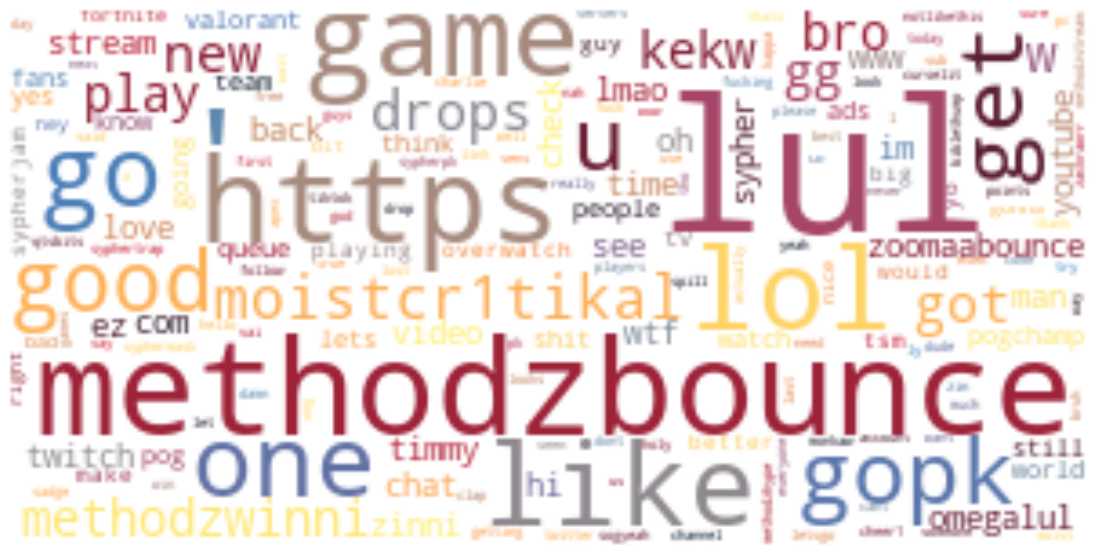

In [ ]:
hero.visualization.wordcloud(chat_df['clean_messages'], font_path = None, width = 300, height = 150, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

# **Now what do we think, from the chat messages, would impact the streamers' behaviors?**

In [ ]:
# Try LDA first?
import gensim

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(chat_df['clean_messages']))

print(data_words[:5])

[['yo', 'first'], ['good', 'steam'], ['hi'], ['yoooo'], ['crosshair']]


In [ ]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:50])

KeyboardInterrupt: ignored

In [ ]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
# !pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

In [ ]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

In [ ]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [5, 10, 15,20], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [ ]:
# Reflections:
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

# **Ignore the code down below**

In [ ]:
## First we take a look at what data there is about the chats
url = video_df['url'][1]
chat = ChatDownloader().get_chat(url)       # create a generator
         # print the formatted message

# For each chat message, this is the full structure
# next(chat)['author']['badges']

pd.DataFrame.from_dict(json_normalize(next(chat)), orient='columns')

,message_id,timestamp,time_in_seconds,source,state,message,time_text,message_type,author.display_name,author.id,author.name,author.type,author.bio,author.created_at,author.images,author.badges,author.colour
0,56dfa958-be91-4bd7-8679-979e1531f545,1665268893255000,10.555,chat,published,We back,0:10,text_message,bobo_n,566592468,bobo_n,user,I would like to remain unknown.Don't check whi...,1597320910088820,[{'url': 'https://static-cdn.jtvnw.net/jtv_use...,"[{'name': 'subscriber', 'version': 12, 'title'...",#FF7F50


In [ ]:
# define function to get chat files.
import itertools

def get_chat(key_series = video_df['url'],n = 5, n_message_limit = 100):
  '''
    key_series is a pandas series of video urls.
    n is the number of videos you wanna pull chat from
    n_message_limit is the limit of messages you wanna pull from each video
    '''
  temp_df = pd.DataFrame()
  for i in range(0,n) :
    url = key_series[i]
    chat = ChatDownloader().get_chat(url)   
        
    top = itertools.islice(chat, n_message_limit)
    
    for message in top:     # iterate over messages
      temp_df_temp = pd.DataFrame.from_dict(json_normalize(next(chat)), orient='columns')

      frames = [temp_df, temp_df_temp]
      temp_df = pd.concat(frames, ignore_index=True)
  
  return temp_df

In [ ]:
chat_df = get_chat(key_series = video_df['url'],n = 2, n_message_limit = 5000)

print(chat_df.shape)
print(chat_df.columns)
chat_df.head(5)

(6823, 18)


,message_id,timestamp,time_in_seconds,source,state,message,time_text,message_type,author.display_name,author.id,author.name,author.type,author.bio,author.created_at,author.images,author.badges,author.colour,emotes
0,0067de3a-3127-48e6-b2e8-706a67cfc81e,1665353970195000,36.495,chat,published,Have good steam!,0:36,text_message,Azkii,39378978,azkii,user,"Hello, I am Azkii. Proud member of the Toad Sq...",1358318766728854,[{'url': 'https://static-cdn.jtvnw.net/jtv_use...,"[{'name': 'premium', 'version': 1, 'title': 'P...",#008000,NaN
1,7fdd1f1d-846b-4999-ae1a-d147a4e48503,1665353978426000,44.726,chat,published,yoooo,0:44,text_message,youngmoneybandz,519136869,youngmoneybandz,user,hey nerd,1587643311316222,[{'url': 'https://static-cdn.jtvnw.net/jtv_use...,"[{'name': 'subscriber', 'version': 6, 'title':...",#00FF7F,NaN
2,741657a0-7d3d-4421-adc5-b113a8239428,1665353978988000,45.288,chat,published,shanenobi - iiTzCrosshair list for Valorant ii...,0:45,text_message,StreamElements,100135110,streamelements,user,Elevate your content with www.StreamElements.c...,1440188714224473,[{'url': 'https://static-cdn.jtvnw.net/jtv_use...,"[{'name': 'moderator', 'version': 1, 'title': ...",#5B99FF,[{'id': 'emotesv2_f1794ecf1c0345c98655087a730f...
3,b774da23-2eb2-4a0d-8408-f396d29e3c8a,1665353982651000,48.951,chat,published,yooooooooooooooo,0:48,text_message,acechopper13,505849553,acechopper13,user,I'm just going to do gaming and nothing but ga...,1585541399427960,[{'url': 'https://static-cdn.jtvnw.net/user-de...,"[{'name': 'premium', 'version': 1, 'title': 'P...",#2E8B57,NaN
4,7631c35a-da75-4a16-a668-919cd6876181,1665353984845000,51.145,chat,published,hi Tim,0:51,text_message,Zed_Hennydog,428976858,zed_hennydog,user,Together we thunder 🇿🇲🇳🇿🌍,1554805481749155,[{'url': 'https://static-cdn.jtvnw.net/jtv_use...,"[{'name': 'premium', 'version': 1, 'title': 'P...",#0000FF,NaN


In [ ]:
# This is a demo of one streamer, 5 messages. 
## Now what do we want to put in a dataframe? 
url = video_df['url'][1]
chat = ChatDownloader().get_chat(url)   

timestamp = []
time_in_seconds = []
messages = []
author_display_name = []
# author_id = []
## Let's hold off the badges and emotes. Those are multi-levels. But they'll be super helpful!!

import itertools

top5 = itertools.islice(chat, 5)

for message in top5:                        # iterate over messages    
    timestamp.append(message['timestamp'])
    time_in_seconds.append(message['time_in_seconds'])
    messages.append(message['message'])
    author_display_name.append(message['author']['display_name'])
    ## better way to flatten. 
    ## can be zipped to a function

#for message in chat:                        # iterate over messages. It's not json!! It's just a dict
#    print(json.dumps(message, indent = 4, sort_keys=True))

chat_df = pd.DataFrame(list(zip(timestamp,time_in_seconds,messages,author_display_name)),
                       columns = ['timestamp','time_in_seconds','messages','author_display_name'])

chat_df.head()
## There're emotes! 

,timestamp,time_in_seconds,messages,author_display_name
0,1665286892922000,14.222,chin shane sort dla piscine,stephanokc
1,1665286915688000,36.988,bye la bonne soireee jvous aiment,NurseScraby
2,1665286956005000,77.305,eille salut les boys !,stephanokc
3,1665286976686000,97.986,Salut la! Jva prob encore cornifler demain si ...,ReactHD9
4,1665286982791000,104.091,oublie pas de temercier l'academie,stephanokc


In [ ]:
chat_df = get_chat(key_series = video_df['url'],n = 5, n_message_limit = 100000)

print(chat_df.shape)
chat_df.head(10)

(1198, 5)


,video_url,timestamp,time_in_seconds,messages,author_display_name
0,https://www.twitch.tv/videos/1619335587,1665298566706000,293.006,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
1,https://www.twitch.tv/videos/1619335587,1665298566890000,293.190,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
2,https://www.twitch.tv/videos/1619335587,1665298567013000,293.313,fergyf1HYPE fergyf1HYPE fergyf1HYPE fergyf1HYPE,FergyFergTV
3,https://www.twitch.tv/videos/1619335587,1665298816474000,542.774,"What can I serve you? ""!drinks"" to order",L3_Bartender
4,https://www.twitch.tv/videos/1619335587,1665298975363000,701.663,allo!,leGlitch
5,https://www.twitch.tv/videos/1619335587,1665299000653000,726.953,pas pire j't'encore réveillé mais pas pour lon...,leGlitch
6,https://www.twitch.tv/videos/1619335587,1665299006146000,732.446,aaaaahhhh poutine,leGlitch
7,https://www.twitch.tv/videos/1619335587,1665299128101000,854.401,jsuis bleu une débarque en bécique a beu ding ...,leGlitch
8,https://www.twitch.tv/videos/1619335587,1665299165171000,891.471,juste pour la toune,leGlitch
9,https://www.twitch.tv/videos/1619335587,1665299257301000,983.601,je game pas avec mes cuisses donc drille mes c...,leGlitch


In [ ]:
# Well, you can even click on the url. That's neat.
chat_df.groupby('video_url')['messages'].count()

video_url
https://www.twitch.tv/videos/1618617417      5
https://www.twitch.tv/videos/1618629121    144
https://www.twitch.tv/videos/1618770779    366
https://www.twitch.tv/videos/1618936117    224
https://www.twitch.tv/videos/1619238405     10
https://www.twitch.tv/videos/1619335587    449
Name: messages, dtype: int64

Now, we need to extract variables from the chat, merge to video_df.

In [ ]:
 = pd.merge(video_df, temp,  how='left', left_on=['video_url'], right_on = ['video_url'])

Parse

In [ ]:
# No need for this anymore.
## parse chat file
def get_chat_dataframe(file):
    data = []
    with open(file, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
        for line in lines:
            #print(line)
            
            time_logged = line.split('UTC')[0][1:].strip()
            #time_logged = datetime.strptime(time_logged,'%Y-%m-%d-%H:%M:%S')
            #print(time_logged)
            
            username_message = line.split(']')[1:]
            username_message = '—'.join(username_message).strip()
            #print(username_message)
            try:
                temp = username_message.split(":")
                username = temp[0]
                message = temp[1]
            except IndexError:
                username = temp[0]
                message = '-'
            #print(username)
            #print(message)
            
            d = {'dt': time_logged,
                 'username': username,
                 'message': message
                    }
            data.append(d)
            
    return pd.DataFrame().from_records(data)

In [ ]:
## This is an example
chat_df = get_chat_dataframe('[1-21-22] Mongraal - Winning Duo Cash Cup With FaZe BL GUILD Flikk (Webcam Mic) - Chat.txt')

chat_df.head()

Cleaning and preprocessing

In [ ]:
# Custom STOPWORDS removal -- Need to think about this.Could use the cloud as below 
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(['yo','play',"twitch","make", "use", "thank", "content", "good", "use",
                                                "think", "need", "harrisheller", "like", "stream",
                                               "kekw","catjam","tim","timthetatman","tatkevinh",
                                               "wipz","docspin","pog","tatlove","lol","lul","omegalul",
                                               "biblethump","clap","tathypers","pepeja","kappa","tattopd","ppsmoke",
                                               "pepelaugh","gopackgo","gachihyper","tatkevinh", "wipz",
                                               "pausechamp","yep","lmao","jack","lulw","monkaw","kreygasm",
                                               "pepega","peped","foxsalt","pogchamp","xqcn","get","back",
                                               "tattuff","tatfat","tatpumpkin","lmao","sadge","sippy",
                                               "pogu","poggers","consolecd","widepeepohappy","pogu","tategg2",
                                               "modcheck","timmy","tathmm","tats","got","com","babyrage",
                                               "xqcp","tatw","pokiw","know", "thats","pepocd","tatafk",
                                               "4weird","tatkkevin", "tatblanket","tatglam","tategg1","wutface",
                                               "blobdance", "kapp","tatbruh","kappapride","facebaby","xqc",
                                               "xqcm","bora","hyperclap","tatlit","5head","gachibass", "go", "ur",
                                                "yes","going","would","im","oh","dez","taty","tk","u","sg", "dont",
                                                "hey","hf","look","anita","anitaheart","leeper","anitahey",
                                                "anitadab","anitadoubt","anitahands", "anitalul","anitapog","anitasword",
                                                "anitaprime","anitafeels","residentsleeper","anitapride","anital",
                                                "anitabiscuit", "thing","widepeeposad","anitahype","among", "lesbianpride",
                                                "heyguys","seemsgood","notlikethis","hi","also","much","yeah",
                                               ])) ## Add as per requirement
# data = hero.remove_stopwords(data, default_stopwords)
chat_df_clean = hero.remove_stopwords(chat_df_temp, custom_stopwords)